In [1]:
import zarr
import numpy as np

# === Your Zarr ===
DIR = '/mnt/efs/aimbl_2025/student_data/S-LS/marker_data.zarr'
z_data = zarr.open(DIR, mode='r')

# === Datasets (as you named them) ===
masks  = z_data['pred_mask_bacteria']['pred_mask_stack'][:]   # (N,H,W), int labels (0=bg, 1..K)
marker = z_data['marker']['marker_stack'][:]                  # (N,H,W), uint16 intensities
raw    = z_data['bacteria']['raw_bacteria_stack'][:]         # (N,H,W), raw image for context

N, H, W = raw.shape
print("shape:", (N, H, W), masks.dtype, marker.dtype, raw.dtype)

shape: (72, 2208, 2752) uint16 uint16 uint16


In [2]:
from skimage.segmentation import expand_labels, find_boundaries
from skimage.morphology import erosion, disk
from skimage.measure import regionprops_table
import matplotlib.pyplot as plt

def band_two_sided(labels2d: np.ndarray, r_out: int = 2, r_in: int = 1) -> np.ndarray:
    """
    Two-sided label-preserving band around each object:
      - Outer band = expand_labels(labels, r_out) minus original labels
      - Inner band = original labels minus per-object erosion by disk(r_in)
    Returns band_labels: same ids as labels on band pixels, 0 elsewhere.
    """
    labels2d = labels2d.astype(np.int32, copy=False)

    # Outer band (keeps instances separate)
    r_out = int(max(0, r_out))
    expanded = expand_labels(labels2d, distance=r_out) if r_out > 0 else labels2d
    outer = expanded.copy()
    outer[labels2d != 0] = 0  # only the newly added outside ring

    # Inner band (per-object erosion to get a thin inner ring)
    r_in = int(max(0, r_in))
    if r_in > 0:
        se = disk(r_in)
        inner = np.zeros_like(labels2d, dtype=np.int32)
        for oid in np.unique(labels2d):
            if oid == 0:
                continue
            obj = (labels2d == oid)
            er = erosion(obj, se)                 # shrink object inward
            inner_ring = obj & (~er)              # original minus eroded = inner band
            inner[inner_ring] = oid
    else:
        inner = np.zeros_like(labels2d, dtype=np.int32)

    band = inner.copy()
    band[outer != 0] = outer[outer != 0]          # union of inner+outer bands
    return band

In [10]:
import matplotlib.pyplot as plt
band_0 = band_two_sided(masks[2], r_out=2, r_in=1)


In [4]:
import numpy as np
from skimage.segmentation import expand_labels
from skimage.measure import regionprops_table

def ring_from_labels(labels2d: np.ndarray, radius: int = 2) -> np.ndarray:
    """Outer ring per instance using label-preserving expansion."""
    expanded = expand_labels(labels2d, distance=radius)
    ring = expanded.copy()
    ring[labels2d != 0] = 0  #  sets all the pixels in ring that correspond to the original label areas back to zero
    return ring


In [11]:

ring_0=ring_from_labels(masks[2], 2) 



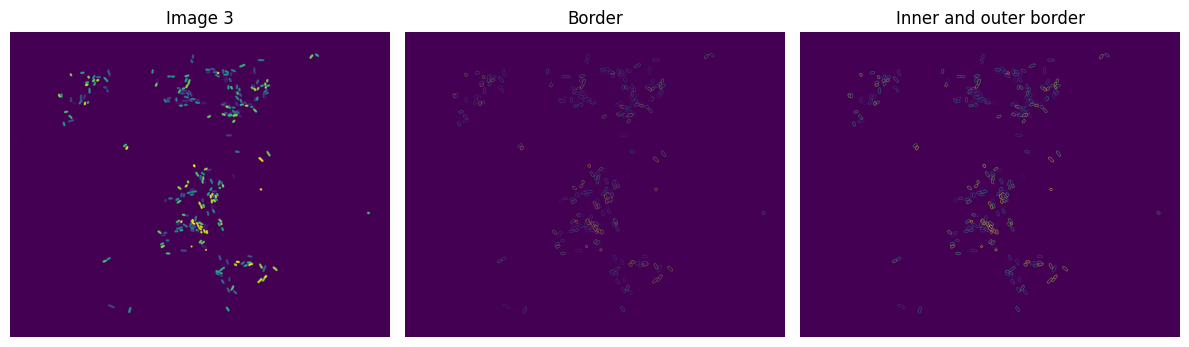

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# Display each image in its subplot
ax[0].imshow(masks[2])
ax[0].set_title("Image 3")
ax[0].axis('off')

ax[1].imshow(ring_0)
ax[1].set_title("Border")
ax[1].axis('off')

ax[2].imshow(band_0)
ax[2].set_title("Inner and outer border")
ax[2].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
def band_coverage_per_label(band_labels: np.ndarray, marker2d: np.ndarray, thr: int, return_area=False):
    """
    Coverage fraction per label on the band:
      coverage[label] = (# band pixels with marker >= thr) / (band area)
    marker2d is uint16; thr should be uint16-ish (e.g., 1200).
    """
    if band_labels.max() == 0:
        return ({}, {}) if return_area else {}

    pos = (marker2d >= thr).astype(np.uint8)  # boolean -> 0/1 so mean = fraction
    props = regionprops_table(
        band_labels, intensity_image=pos,
        properties=("label", "mean_intensity", "area")
    )
    coverage = {int(l): float(m) for l, m in zip(props["label"], props["mean_intensity"])} #mean intensity divides it across the area
    if return_area:
        area = {int(l): int(a) for l, a in zip(props["label"], props["area"])}
        return coverage, area
    return coverage

In [16]:
coverage_3=band_coverage_per_label(band_0, marker[2], thr=1400)
print(coverage_3)

{1: 0.0, 2: 0.0, 3: 0.7719298245614035, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.6995515695067265, 8: 0.8164251207729468, 9: 0.4689922480620155, 10: 0.06896551724137931, 11: 0.059748427672955975, 12: 0.9196787148594378, 13: 0.31950207468879666, 14: 0.0, 15: 0.6388888888888888, 16: 0.6303501945525292, 17: 0.0, 18: 0.2740740740740741, 19: 0.6728971962616822, 20: 0.0, 21: 0.182648401826484, 22: 0.012269938650306749, 23: 0.0, 24: 0.21634615384615385, 25: 0.0, 26: 0.0, 27: 0.46607669616519176, 28: 0.19421487603305784, 29: 0.15315315315315314, 30: 0.4069264069264069, 31: 0.0, 32: 0.0, 33: 0.4069264069264069, 34: 0.5352112676056338, 35: 0.0, 36: 0.18072289156626506, 37: 0.8743169398907104, 38: 0.4787234042553192, 39: 0.6818181818181818, 40: 0.20224719101123595, 41: 0.0, 42: 0.47533632286995514, 43: 0.08786610878661087, 44: 0.019230769230769232, 45: 0.0, 46: 0.5138888888888888, 47: 0.22764227642276422, 48: 0.9475308641975309, 49: 0.5909090909090909, 50: 0.12962962962962962, 51: 0.0, 52: 0.0, 53: 0.5425531

In [21]:
# print(coverage_3.get(int(3), 0.0))
print(coverage_3.get(int(6)))

0.0


In [24]:
COVERAGE_MIN = 0.5       # "at least half the band"
THR = 1400     # set after you’re happy with the visuals
R_OUT = 2
R_IN = 1

total_pos = total_inst = 0
per_image = []

# for i in range(N):
for i in range(3):
    lbl = masks[i]
    mrk = marker[i]
    band = band_two_sided(lbl, r_out=R_OUT, r_in=R_IN)

    coverage, area = band_coverage_per_label(band, mrk, thr=THR, return_area=True)
    ids = np.unique(lbl); ids = ids[ids != 0]
    n_inst = int(len(ids))
    #n_pos  = sum(1 for oid in ids if coverage.get(int(oid), 0.0) >= COVERAGE_MIN)
    n_pos  = sum(1 for oid in ids if coverage.get(int(oid)) >= COVERAGE_MIN)

    total_pos += n_pos
    total_inst += n_inst
    per_image.append((i, n_inst, n_pos))

print(f"Band: r_out={R_OUT}, r_in={R_IN} | Marker thr={THR} (uint16) | Coverage≥{COVERAGE_MIN}")
print(f"Colocalizing bacteria: {total_pos}/{total_inst}  ({100*total_pos/max(total_inst,1):.1f}%)")
for i, n_inst, n_pos in per_image:
    print(f"Image {i:03d}: positives={n_pos}/{n_inst}")

Band: r_out=2, r_in=1 | Marker thr=1400 (uint16) | Coverage≥0.5
Colocalizing bacteria: 133/529  (25.1%)
Image 000: positives=32/136
Image 001: positives=41/128
Image 002: positives=60/265


Figuring out the intensity

In [25]:
from skimage.filters import threshold_otsu

# Collect all band pixels across the dataset to suggest a global threshold
all_band_vals = []
# for i in range(N):
for i in range(3):
    band = band_two_sided(masks[i], r_out=R_OUT, r_in=R_IN)
    vals = marker[i][band != 0]
    if vals.size:
        all_band_vals.append(vals.astype(np.uint16))
all_band_vals = np.concatenate(all_band_vals) if all_band_vals else np.array([], dtype=np.uint16)

if all_band_vals.size:
    otsu_thr = int(threshold_otsu(all_band_vals))
    p10, p50, p90 = np.percentile(all_band_vals, [10, 50, 90])
    print(f"Global Otsu (band pixels): {otsu_thr} | band percentiles: p10={p10:.0f}, p50={p50:.0f}, p90={p90:.0f}")
else:
    print("No band pixels found for Otsu.")

Global Otsu (band pixels): 1676 | band percentiles: p10=209, p50=633, p90=2518


In [29]:
p10, p50, p60 = np.percentile(all_band_vals, [10, 50, 60])
print(f"Global Otsu (band pixels): {otsu_thr} | band percentiles: p10={p10:.0f}, p50={p50:.0f}, p60={p60:.0f}")

Global Otsu (band pixels): 1676 | band percentiles: p10=209, p50=633, p60=846


In [26]:
COVERAGE_MIN = 0.5       # "at least half the band"
THR = 633     # set after you’re happy with the visuals
R_OUT = 2
R_IN = 1

total_pos = total_inst = 0
per_image = []

# for i in range(N):
for i in range(3):
    lbl = masks[i]
    mrk = marker[i]
    band = band_two_sided(lbl, r_out=R_OUT, r_in=R_IN)

    coverage, area = band_coverage_per_label(band, mrk, thr=THR, return_area=True)
    ids = np.unique(lbl); ids = ids[ids != 0]
    n_inst = int(len(ids))
    #n_pos  = sum(1 for oid in ids if coverage.get(int(oid), 0.0) >= COVERAGE_MIN)
    n_pos  = sum(1 for oid in ids if coverage.get(int(oid)) >= COVERAGE_MIN)

    total_pos += n_pos
    total_inst += n_inst
    per_image.append((i, n_inst, n_pos))

print(f"Band: r_out={R_OUT}, r_in={R_IN} | Marker thr={THR} (uint16) | Coverage≥{COVERAGE_MIN}")
print(f"Colocalizing bacteria: {total_pos}/{total_inst}  ({100*total_pos/max(total_inst,1):.1f}%)")
for i, n_inst, n_pos in per_image:
    print(f"Image {i:03d}: positives={n_pos}/{n_inst}")

Band: r_out=2, r_in=1 | Marker thr=633 (uint16) | Coverage≥0.5
Colocalizing bacteria: 271/529  (51.2%)
Image 000: positives=64/136
Image 001: positives=66/128
Image 002: positives=141/265


In [30]:
COVERAGE_MIN = 0.5       # "at least half the band"
THR = 846    # set after you’re happy with the visuals
R_OUT = 2
R_IN = 1

total_pos = total_inst = 0
per_image = []

# for i in range(N):
for i in range(3):
    lbl = masks[i]
    mrk = marker[i]
    band = band_two_sided(lbl, r_out=R_OUT, r_in=R_IN)

    coverage, area = band_coverage_per_label(band, mrk, thr=THR, return_area=True)
    ids = np.unique(lbl); ids = ids[ids != 0]
    n_inst = int(len(ids))
    #n_pos  = sum(1 for oid in ids if coverage.get(int(oid), 0.0) >= COVERAGE_MIN)
    n_pos  = sum(1 for oid in ids if coverage.get(int(oid)) >= COVERAGE_MIN)

    total_pos += n_pos
    total_inst += n_inst
    per_image.append((i, n_inst, n_pos))

print(f"Band: r_out={R_OUT}, r_in={R_IN} | Marker thr={THR} (uint16) | Coverage≥{COVERAGE_MIN}")
print(f"Colocalizing bacteria: {total_pos}/{total_inst}  ({100*total_pos/max(total_inst,1):.1f}%)")
for i, n_inst, n_pos in per_image:
    print(f"Image {i:03d}: positives={n_pos}/{n_inst}")

Band: r_out=2, r_in=1 | Marker thr=846 (uint16) | Coverage≥0.5
Colocalizing bacteria: 212/529  (40.1%)
Image 000: positives=42/136
Image 001: positives=58/128
Image 002: positives=112/265


### The threshold that worked better was 846 (percentile 60)

In [31]:
def band_intensity_stats(band_labels: np.ndarray, marker2d: np.ndarray):
    """
    (Optional) Mean/Max intensity per label on the band (not thresholded).
    Useful for exploring intensity distributions before picking a threshold.
    """
    if band_labels.max() == 0:
        return {}, {}, {}, {}
    props = regionprops_table(
        band_labels, intensity_image=marker2d.astype(np.float32),
        properties=("label", "mean_intensity", "max_intensity", "area", "bbox")
    )
    mean_by = {int(l): float(m) for l, m in zip(props["label"], props["mean_intensity"])}
    max_by  = {int(l): float(m) for l, m in zip(props["label"], props["max_intensity"])}
    area_by = {int(l): int(a)   for l, a in zip(props["label"], props["area"])}
    bbox_by = {
        int(l): (int(r0), int(c0), int(r1), int(c1))
        for l, r0, c0, r1, c1 in zip(
            props["label"], props["bbox-0"], props["bbox-1"], props["bbox-2"], props["bbox-3"]
        )
    }
    return mean_by, max_by, area_by, bbox_by

def crop_with_margin(y0, x0, y1, x1, margin, H, W):
    y0 = max(0, y0 - margin); x0 = max(0, x0 - margin)
    y1 = min(H, y1 + margin); x1 = min(W, x1 + margin)
    return y0, x0, y1, x1

def rescale_for_display(arr, p_lo=1, p_hi=99.5):
    """Percentile-based rescale to [0,1] for prettier plots (doesn't affect analysis)."""
    a = arr.astype(np.float32)
    lo, hi = np.percentile(a, [p_lo, p_hi])
    if hi <= lo:
        return np.clip((a - lo), 0, 1)
    a = (a - lo) / (hi - lo)
    return np.clip(a, 0, 1)

index instances once (band: per label stats)

In [32]:
R_OUT = 2   # outer pixels
R_IN  = 1   # inner pixels

index = []  # list of dicts: {img_i, label, mean, max, bbox}

#for i in range(N):
for i in range(3):
    lbl = masks[i]
    if lbl.max() == 0:
        continue
    band = band_two_sided(lbl, r_out=R_OUT, r_in=R_IN)
    mean_by, max_by, area_by, bbox_by = band_intensity_stats(band, marker[i])

    for oid, bbox in bbox_by.items():
        index.append({
            "img_i": i,
            "label": int(oid),
            "mean": float(mean_by.get(oid, 0.0)),
            "max":  float(max_by.get(oid, 0.0)),
            "bbox": bbox
        })
    print("Finished image", i)

# print(f"Indexed {len(index)} instances across {N} images (r_out={R_OUT}, r_in={R_IN}).")
print(f"Indexed {len(index)} instances across 3 images (r_out={R_OUT}, r_in={R_IN}).")

Finished image 0
Finished image 1
Finished image 2
Indexed 529 instances across 3 images (r_out=2, r_in=1).


In [43]:
def show_examples_coverage(index, thr: int, coverage_min=0.5, n=12, mode="positive", margin=6, seed=0):
    """
    mode: 'positive' (coverage>=min), 'negative' (<min), 'near' (within ±10% of min)
    """
    rng = np.random.default_rng(seed)

    # Compute coverage per instance (given thr) on the fly
    cov_vals = []
    for item in index:
        i, oid = item["img_i"], item["label"]
        band = band_two_sided(masks[i], r_out=R_OUT, r_in=R_IN)
        cov = band_coverage_per_label(band, marker[i], thr=thr)
        cov_vals.append(cov.get(oid, 0.0))
        print("finished with item", i, oid)
    cov_vals = np.array(cov_vals, dtype=float)

    if mode == "positive":
        sel = np.where(cov_vals >= coverage_min)[0]
    elif mode == "negative":
        sel = np.where(cov_vals < coverage_min)[0]
    elif mode == "near":
        lo, hi = 0.9*coverage_min, 1.1*coverage_min
        sel = np.where((cov_vals >= lo) & (cov_vals <= hi))[0]
    else:
        raise ValueError("mode must be 'positive', 'negative', or 'near'")

    if sel.size == 0:
        print("No examples match this filter.")
        return

    rng.shuffle(sel)
    sel = sel[:n]
    rows = len(sel); cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(6, 2.5*rows))
    if rows == 1:
        axes = np.array([axes])

    for r, k in enumerate(sel):
        item = index[int(k)]
        i, oid = item["img_i"], item["label"]
        y0, x0, y1, x1 = crop_with_margin(*item["bbox"], margin, H, W)

        img_raw = rescale_for_display(raw[i][y0:y1, x0:x1])
        img_mrk = rescale_for_display(marker[i][y0:y1, x0:x1].astype(np.float32))

        # Build overlays
        lbl_crop  = (masks[i][y0:y1, x0:x1] == oid)
        bnd_crop  = find_boundaries(lbl_crop, mode="outer")
        full_band = band_two_sided(masks[i], r_out=R_OUT, r_in=R_IN)
        band_crop = (full_band[y0:y1, x0:x1] == oid)

        # Coverage again for this object (for annotation)
        cov = band_coverage_per_label(full_band, marker[i], thr=thr).get(oid, 0.0)

        axL = axes[r, 0]
        axL.imshow(img_raw, cmap="gray")
        axL.contour(bnd_crop, levels=[0.5], linewidths=1.0)
        axL.set_title(f"img {i}, id {oid}\ncoverage={cov:.2f}")
        axL.axis("off")

        axR = axes[r, 1]
        axR.imshow(img_mrk, cmap="gray")
        axR.contour(band_crop, levels=[0.5], linewidths=1.0)
        axR.set_title(f"marker ≥ {thr} (uint16)\nband r_out={R_OUT}, r_in={R_IN}")
        axR.axis("off")

    fig.suptitle(f"Examples ({mode}) — coverage≥{coverage_min}", y=0.995)
    plt.tight_layout()
    plt.show()

In [41]:
print(index[2])

{'img_i': 0, 'label': 3, 'mean': 3182.820068359375, 'max': 5228.0, 'bbox': (1911, 1703, 1972, 1726)}


In [46]:
R_OUT = 2   # outer pixels
R_IN  = 1   # inner pixels


lbl = masks[2]

band = band_two_sided(lbl, r_out=R_OUT, r_in=R_IN)
mean_by, max_by, area_by, bbox_by = band_intensity_stats(band, marker[i])

for oid, bbox in bbox_by.items():
    index.append({
        "img_i": 2,
        "label": int(oid),
        "mean": float(mean_by.get(oid, 0.0)),
        "max":  float(max_by.get(oid, 0.0)),
        "bbox": bbox
    })
print("Finished image", i)

Finished image 2


In [47]:
# === Pick a candidate threshold in uint16, then preview ===
THR_CANDIDATE = 846   # <-- choose based on browsing / Otsu / biology
show_examples_coverage(index, thr=THR_CANDIDATE, coverage_min=0.5, n=10, mode="positive", margin=6, seed=1)
print("near")
# show_examples_coverage(index, thr=THR_CANDIDATE, coverage_min=0.5, n=10, mode="near",     margin=6, seed=2)
# print("negative")
# show_examples_coverage(index, thr=THR_CANDIDATE, coverage_min=0.5, n=10, mode="negative", margin=6, seed=3)

finished with item 0 1
finished with item 0 2
finished with item 0 3
finished with item 0 4
finished with item 0 5
finished with item 0 6
finished with item 0 7
finished with item 0 8
finished with item 0 9
finished with item 0 10
finished with item 0 11
finished with item 0 12
finished with item 0 13
finished with item 0 14
finished with item 0 15
finished with item 0 16
finished with item 0 17
finished with item 0 18
finished with item 0 19
finished with item 0 20
finished with item 0 21
finished with item 0 22
finished with item 0 23
finished with item 0 24
finished with item 0 25
finished with item 0 26
finished with item 0 27
finished with item 0 28
finished with item 0 29
finished with item 0 30
finished with item 0 31
finished with item 0 32
finished with item 0 33
finished with item 0 34
finished with item 0 35
finished with item 0 36
finished with item 0 37
finished with item 0 38
finished with item 0 39
finished with item 0 40
finished with item 0 41
finished with item 0 42
f

KeyboardInterrupt: 